# COGS 118A - Final Project

## Prediction of Chess Game Outcomes Based on Player Features

# Names

Hopefully your team is at least this good.

- Omri Habot
- Keate Ehrenburg
- Jacob Lamadrid
- Alex Bumbalov

# Abstract

The goal of this project is to examine the effectiveness of different models in predicting the outcome of a chess match. The data used in this project will contain features describing players’ technical skill and experience including the Elo rating of each player, the number of games they have played, the number of wins/losses/draws they have achieved, their age, and the length of the game. These are measured by observing the outcomes of every game in a player’s career. We will use this data to perform feature selection and single out the most relevant features, and then we will train the models and compare their predictive accuracies. Accuracy will be measured by classification error metrics including precision, recall, f1-score, and possibly others, which we will compare across models to observe their relative efficacies.

# Background

Within the world of chess competitions and general play, machine learning and deep learning have been famously applied in such algorithms as Deep Blue, Stockfish, etc. These algorithms historically have aimed to predict the next best move to be executed as well as the win probability at any given position state [1](https://arxiv.org/pdf/2109.11602.pdf). This win probability is what we aim to place our project emphasis upon as in similar works in varying competitive settings, most relevant of which is found in esports win/loss classification based upon player/team rankings and typical movesets among many other features [2](https://arxiv.org/pdf/2108.02799.pdf). The application of these algorithms in returning win probability and outcome prediction has large impacts in the way one chooses to learn chess or the way in which a machine is taught how to play chess. This may also have implications for the way in which new strategies or entire play styles are formed. These implications have already manifested themselves in the competitive playspace as many players look towards Stockfish evaluations for input on their play or for other engines in which competition may aid in their training as “with the help of chess engines, Grandmasters are now able to plan prepare for their games in extreme depth, sometimes memorizing up to 15-20 moves of their openings” [3](https://fluency.mcsaatchi.com/2022/09/01/the-evolution-of-chess-ai/#:~:text=Artificial%20intelligence%20has%20completely%20changed,20%20moves%20of%20their%20openings.). In order to approach the problem of finding an appropriate machine learning prediction method , we are going to need a large amount of chess match data to work with. We have chosen to use the Free Internet Chess Server(FICS) database. The database has been collecting all rated and unrated games played on FICS since October of 2008. With over 200 million games stored, this will provide us with plenty of data to address our goal of outcome classification.

Our models will train similarly to current chess engines, utilizing previous games played in order to gain improve decision making and outcome prediction, as in the models created by the chess.com website, with machine learning algorithms such as Luk.AI which improves its elo with every game played.

# Problem Statement

The problem we will be addressing is determining which machine learning method best predicts the winner of a chess game depending on variables like participating players, player statistics and scores such as their Elo’s, the opening, and psychological factors of the players, among others. We plan to explore this problem by trying three different machine learning algorithms: logistic regression, random forest, and deep neural network. Logistic regression is a solid classification method. While we fear that it may be too simple for this task, we believe it is a simple baseline to compare with other, more complex models. We plan to try random forests because the complex decision boundaries may be sufficient for consistently accurate and generalizable predictions. Finally, we plan on using a deep neural network because it seems to be the baseline method used for very similar problems, and given our large dataset, we hope it will pick up on important nuances that are neglected by logistic regression and random forest. We will use labeled chess game data that denotes the winner of each game as well as the aforementioned variables that describe the game. Each model will be trained using the same (or similar) dataset and evaluated with the same set of classification error metrics such that we can compare their efficacies. These metrics include precision, recall, f1-score, and others.

# Data

We will be using the [Free Internet Chess Server (FICS)](https://www.ficsgames.org/dl/ficsgamesdb_202301_blitz2000_movetimes_278527.pgn.bz2) as our database for analysis. The dataset comes in the Portable Game Notation (PGN) file format, which is a common data format for representing chess games. We will need to convert this into a pandas dataframe for our analysis, so we will write a function that parses through the PGN file as text and builds a dataframe from it. Once the data is parsed, we will simply need to convert each column into the appropriate datatype, so numbers would be int32 or float64, words will be strings, binary features will be boolean, etc.

There are many different types of chess games from which we can choose that would cause nuances in our analysis and results. We selected blitz games because their rapid nature produces more variability in game moves, and therefore outcomes. We hope that this variability gives us more data to work with when predicting outcomes. Our dataset has 25884 complete observations (each representing a chess game) as well as 22 features describing each game (before one-hot encoding). Each observation consists of the moves made throughout the game, the date and time played, the players and their colors, player Elo, match result, and game variant and time control information for each match. One of the most critical features is `playerElo`, a score representing the relative skill levels of players, since this is likely one of the biggest predictors of the outcome. This is represented by an arbitrary number that can indicate a player's relative skill level when compared to other players. Another crucial feature is `moves`, which outlines all the moves made in the game. We can use this sequential data to build more complex models and make more nuanced predictions.

#### Features
Here is a summary of the features we retrieved, cleaned, and constructed.

|__Feature__| __Description__|
|---|---|
|Date| date of the game|
|White| player playing white|
|Black| player playing black|
|Result| outcome of the game|
|BlackElo| relative skill rating of black player|
|BlackIsComp|whether black is the computer|
|BlackRD|rating deviation of black player|
|ECO|the code for the opening|
|FICSGamesDBGameNo|number of game in database|
|PlyCount|total number of plays throughout the game|
|Time|time allowed for each move|
|TimeControl|total amount of time each player has to complete their portion of the game|
|WhiteElo| relative skill rating of white player|
|WhiteIsComp|whether white is the computer|
|WhiteRD|rating deviation of black player|
|AvgEvalOpening|the engine evaluation for each move is generated, then averaged for the first 1/3 of moves in the game|
|AvgEvalMiddle|the engine evaluation for each move is generated, then averaged for the second 1/3 of moves in the game|
|AvgEvalEnd|the engine evaluation for each move is generated, then averaged for the final 1/3 of moves in the game|
|AvgEmtOpening|the elapsed move time for each move is generated, then averaged for the first 1/3 of moves in the game|
|AvgEmtMiddle|the elapsed move time for each move is generated, then averaged for the second 1/3 of moves in the game|
|AvgEmtEnd|the elapsed move time for each move is generated, then averaged for the final 1/3 of moves in the game|
|ResultComment| the specific description of the result|

### Data Cleaning and Importing

The database provides chess game data in the PGN file format. In order to convert the data into a dataframe and proceed with our analysis, we wrote scripts to parse our desired variables from PGN files and produce CSV files. Afterwards, we imported the CSV's as dataframes and cleaned them up such that each feature had the proper datatype. 

In [9]:
# Cleaning
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

# import all csv's from a folder and combine them into one dataframe
def combine_data_files(folder_path):
    df_list = []

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path)
            df_list.append(df)

    return pd.concat(df_list, axis=0, ignore_index=True)

# clean up the datatypes of the imported dataframes
def clean_df_new(df):
    
    resMap = lambda res : 'White' if res == '1-0' else 'Black' if res == '0-1' else 'Draw' if res == "1/2-1/2" else res
    cleanDateTime = lambda d: pd.to_datetime(d)
    cleanComment = lambda x: x if x.find(']') == -1 else x.split("] ")[1]

    # assign proper types to each column
    datetime_columns = ['Date', 'Time', 'WhiteClock', 'BlackClock']
    float_columns = ['WhiteRD', 'BlackRD', 'AvgEvalOpening', 'AvgEvalMiddle', 'AvgEvalEnd', 'AvgEmtOpening', 'AvgEmtMiddle', 'AvgEmtEnd']
    int_columns = ['FICSGamesDBGameNo', 'WhiteElo', 'BlackElo', 'PlyCount']

    # eliminate useless columns
    df = df.drop(['Event', 'Site', 'Round', 'WhiteClock', 'BlackClock'], axis=1)

    for column in df.columns:

        if column in float_columns:
            df[column] = df[column].astype(float)
        elif column in int_columns:
            df[column] = df[column].astype(int)
        elif column in datetime_columns:
            df[column] = df[column].apply(cleanDateTime)
        else:
            if column == 'Result':
                df[column] = df[column].apply(resMap)
            if column == 'ResultComment':
                df[column] = df[column].apply(cleanComment)
            df[column] = df[column].astype('category')

    df['WhiteIsComp'] = df['WhiteIsComp'] == 'Yes'
    df['BlackIsComp'] = df['BlackIsComp'] == 'Yes'

    return df

In [34]:
combined_df = combine_data_files('data-by-month')
cleaned = clean_df_new(combined_df).dropna()
print('Number of observations: ' + str(cleaned.shape[0]))
print('Number of features (before one-hot encoding): ' + str(cleaned.shape[1]))
cleaned.head()

Number of observations: 25884
Number of features (before one-hot encoding): 22


,Date,White,Black,Result,BlackElo,BlackRD,ECO,FICSGamesDBGameNo,PlyCount,Time,...,WhiteRD,AvgEvalOpening,AvgEvalMiddle,AvgEvalEnd,AvgEmtOpening,AvgEmtMiddle,AvgEmtEnd,ResultComment,BlackIsComp,WhiteIsComp
0,2022-04-30,Indrayoga,Ripple,White,1979,55.2,B31,511547590,47,2023-03-22 23:38:00,...,40.8,53.687500,195.533333,209.535714,1.362933,1.871933,4.876200,Black checkmated,False,False
1,2022-04-30,Notarious,ArasanX,Draw,2778,37.2,C89,511547000,60,2023-03-22 20:38:00,...,36.6,54.952381,40.800000,8.210526,0.128400,0.143400,2.877579,Game drawn by mutual agreement,True,True
2,2022-04-30,fary,damouno,Black,2293,49.3,A40,511546226,68,2023-03-22 17:33:00,...,65.6,37.956522,-53.681818,-143.735294,0.634182,2.320136,1.531818,White checkmated,False,False
3,2022-04-30,exeComp,Notarious,Draw,2813,36.7,C67,511546220,213,2023-03-22 16:46:00,...,39.3,21.527778,1.647887,0.000000,6.186042,2.866211,0.604500,Game drawn by the 50 move rule,True,True
4,2022-04-30,dmgrant,Speyside,Draw,2162,48.2,D31,511546118,76,2023-03-22 17:01:00,...,99.7,-41.730769,-117.200000,199.600000,1.865720,2.839560,2.971680,Game drawn by repetition,True,False


After cleaning the datatypes, we performed the last processing step: applying one-hot encoding to categorical features and converting redundant numerical features into averages.

In [11]:
# additional processing: perform one-hot encoding and take average of given numerical columns
def construct_df_train(df):
    # Define columns to take the average of and to one-hot encode
    cols_to_avg = ['WhiteRD', 'BlackRD', 'AvgEvalOpening', 'AvgEvalMiddle', 'AvgEvalEnd', 'AvgEmtOpening', 'AvgEmtMiddle', 'AvgEmtEnd', 'PlyCount']
    cols_to_onehot = ['ECO'] # 'White', 'Black',  <--- For if we decide to train using player UN for black and white as a features
    ground_truth_labels = ['Result', 'ResultComment']

    # Define dictionary to map column names to letters for one-hot encoding
    col_name_to_letter = {col_name: chr(65+i) for i, col_name in enumerate(ground_truth_labels+cols_to_onehot)}

    # Define column names for player-wise averages
    new_cols_white = ['WhiteAvgRD', 'WhiteAvgEvalForOpenings', 'WhiteAvgEvalForMiddlegames', 'WhiteAvgEvalForEndgames', 'WhiteAvgEmtForOpenings', 'WhiteAvgEmtForMiddlegames', 'WhiteAvgEmtForEndgames', 'WhiteAvgPlyCount']
    new_cols_black = ['BlackAvgRD', 'BlackAvgEvalForOpenings', 'BlackAvgEvalForMiddlegames', 'BlackAvgEvalForEndgames', 'BlackAvgEmtForOpenings', 'BlackAvgEmtForMiddlegames', 'BlackAvgEmtForEndgames', 'BlackAvgPlyCount']

    # Compute player-wise averages
    dataAvgsByUserWhite = {p: df[df['White'] == p][cols_to_avg+cols_to_onehot].mean(numeric_only=True) for p in df['White'].unique()}
    dataAvgsByUserBlack = {p: df[df['Black'] == p][cols_to_avg+cols_to_onehot].mean(numeric_only=True) for p in df['Black'].unique()}

    # Define empty dataframe to hold the new data
    df_new = pd.DataFrame(columns = ground_truth_labels+cols_to_onehot+new_cols_white+new_cols_black)

    # Iterate over each row in the original dataframe and create a new row in the output dataframe with the necessary data
    for row in df.itertuples():
        white_avg_values = dataAvgsByUserWhite.get(row.White, pd.Series([0]*len(cols_to_avg+cols_to_onehot)))
        black_avg_values = dataAvgsByUserBlack.get(row.Black, pd.Series([0]*len(cols_to_avg+cols_to_onehot)))

        white_new_cols = [white_avg_values[0], white_avg_values[2], white_avg_values[3], white_avg_values[4], white_avg_values[5], white_avg_values[6], white_avg_values[7], white_avg_values[8]]
        black_new_cols = [black_avg_values[1], black_avg_values[2], black_avg_values[3], black_avg_values[4], black_avg_values[5], black_avg_values[6], black_avg_values[7], black_avg_values[8]]

        new_row = tuple(getattr(row, label) for label in ground_truth_labels+cols_to_onehot) + tuple(white_new_cols) + tuple(black_new_cols)

        df_new.loc[len(df_new)] = new_row

    # One-hot encode the ground truth labels and cols_to_onehot
    df_new = pd.get_dummies(df_new, columns = ground_truth_labels+cols_to_onehot, prefix = list(col_name_to_letter.values()))

    # Map the column labels to their corresponding uppercase letters
    df_new.columns = df_new.columns.map(lambda x: col_name_to_letter.get(x, x))

    return df_new

In [12]:
df_train = construct_df_train(cleaned)
print('Number of observations: ' + str(df_train.shape[0]))
print('Number of features (after one-hot encoding): ' + str(df_train.shape[1]))
df_train.head()

Number of observations: 25884
Number of features (after one-hot encoding): 517


,WhiteAvgRD,WhiteAvgEvalForOpenings,WhiteAvgEvalForMiddlegames,WhiteAvgEvalForEndgames,WhiteAvgEmtForOpenings,WhiteAvgEmtForMiddlegames,WhiteAvgEmtForEndgames,WhiteAvgPlyCount,BlackAvgRD,BlackAvgEvalForOpenings,...,C_E87,C_E88,C_E90,C_E91,C_E92,C_E93,C_E94,C_E95,C_E96,C_E97
0,37.547788,79.217020,208.169533,281.785318,2.452644,3.257611,3.044591,64.035398,59.120000,37.755580,...,0,0,0,0,0,0,0,0,0,0
1,34.851760,54.018170,128.992509,265.426934,1.435165,2.490632,2.255974,101.928292,30.245794,24.857252,...,0,0,0,0,0,0,0,0,0,0
2,56.357143,13.223769,-88.944439,-183.419927,0.821016,1.903376,3.935707,59.857143,37.653209,-14.124663,...,0,0,0,0,0,0,0,0,0,0
3,34.075718,45.014569,104.508098,195.642712,2.104136,3.775255,3.686790,92.955514,35.060330,-4.545055,...,0,0,0,0,0,0,0,0,0,0
4,80.766667,29.894066,15.228401,88.172416,1.119153,1.686435,1.407838,81.777778,34.200000,52.580662,...,0,0,0,0,0,0,0,0,0,0


### Brief EDA

We will demonstrate some very brief EDA to provide a sense of the data we have. 

In [13]:
import seaborn as sns

In [14]:
outcomes = cleaned[['WhiteElo', 'BlackElo', 'Result']]
outcomes['EloDiff (White-Black)'] = outcomes['WhiteElo'] - outcomes['BlackElo']
outcomes.head()

,WhiteElo,BlackElo,Result,EloDiff (White-Black)
0,2062,1979,White,83
1,2810,2778,Draw,32
2,1831,2293,Black,-462
3,2691,2813,Draw,-122
4,2148,2162,Draw,-14


<Axes: ylabel='Result'>

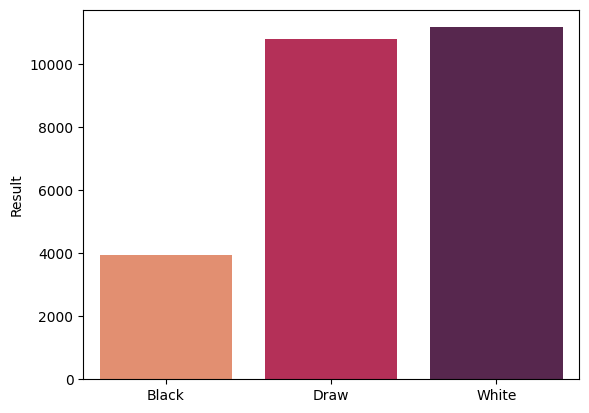

In [15]:
sns.barplot(x = outcomes['Result'].unique(), y=outcomes['Result'].value_counts(), palette='rocket_r')

There is an unbalanced representation of match outcome. While there is a similar amount of draws and white wins, there seem to be very few black-win outcomes. This warrants further analysis--if winning actually depends on the color, then this is alright. However, if this is not the case, then we may need to upsample the black-win observations to make our dataset more balanced.

<Axes: xlabel='Result', ylabel='EloDiff (White-Black)'>

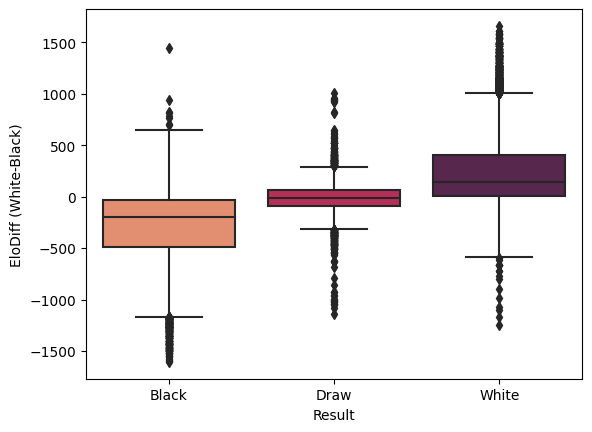

In [16]:
sns.boxplot(data=outcomes, x='Result', y='EloDiff (White-Black)', palette='rocket_r')

This graph shows that, generally, the color which someone plays as is not a great indicator of of who is the winner. It is more the case that the player with the higher Elo rating tends to win, and draws often happen between two players with very similar Elo ratings.

In [17]:
evals = df_train[df_train.columns[df_train.columns.str.contains('Eval') + df_train.columns.str.contains('Result')]]
evals['Result'] = cleaned['Result']
evals['DiscreetResult'] = cleaned['Result'].apply(lambda s: 1 if s == 'Black' else 2 if s == 'Draw' else 3).astype(int)

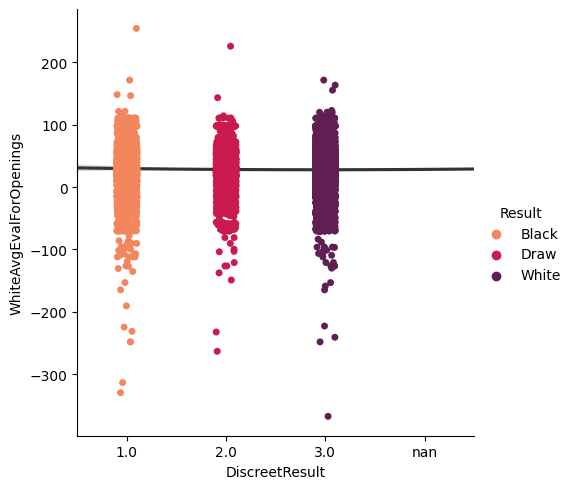

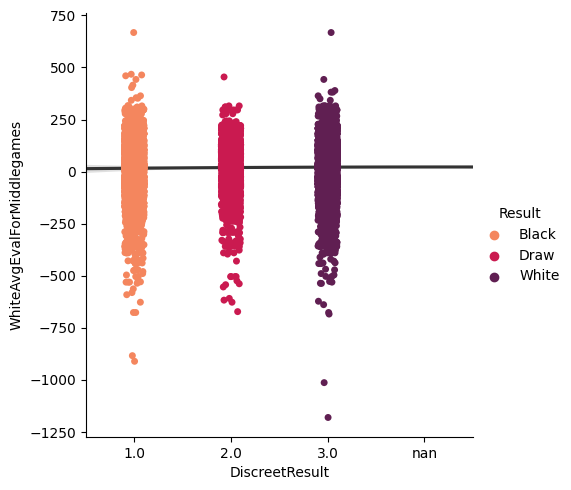

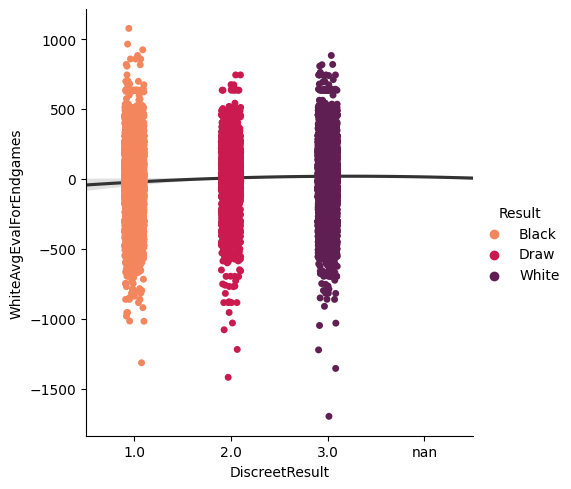

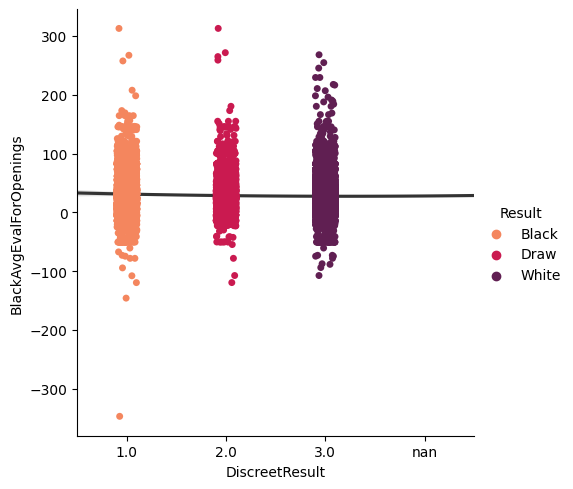

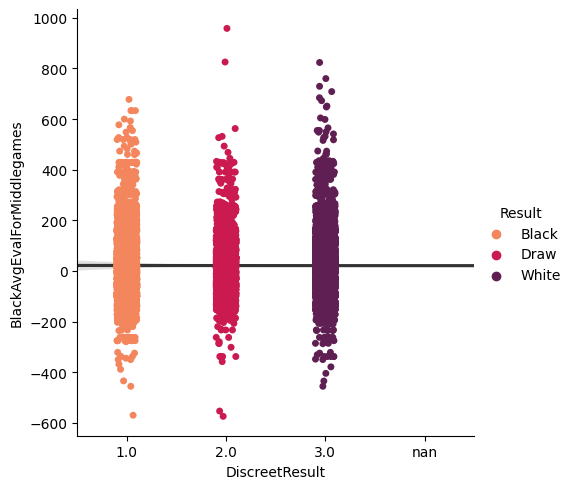

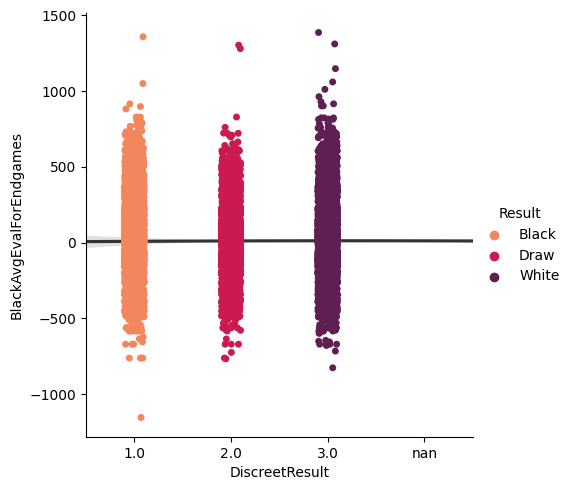

In [18]:
for col in evals.columns[:-2]:

    sns.catplot(data=evals, x='DiscreetResult', 
                y=col,
                hue='Result',
                palette='rocket_r')

    sns.regplot(data=evals, x='DiscreetResult', 
                y=col,
                scatter=False, truncate=False, order=2, color=".2")

From these plots, we see slight interactions between the average evaluation of a players opening, middle, and end games and the result of the match. While this is still worth taking into consideration in our models, this interaction is extremely slight and will therefore need to be scaled accordingly. An apparent issue with this measurement is the distribution of player evaluations with a large tendency to the mean of 0 and some notable outliers. This leaves the regression biased towards the center. Individual evals can change drastically throughout the match so we need to focus more on the interaction between players evaluations rather than just the individual player scores.

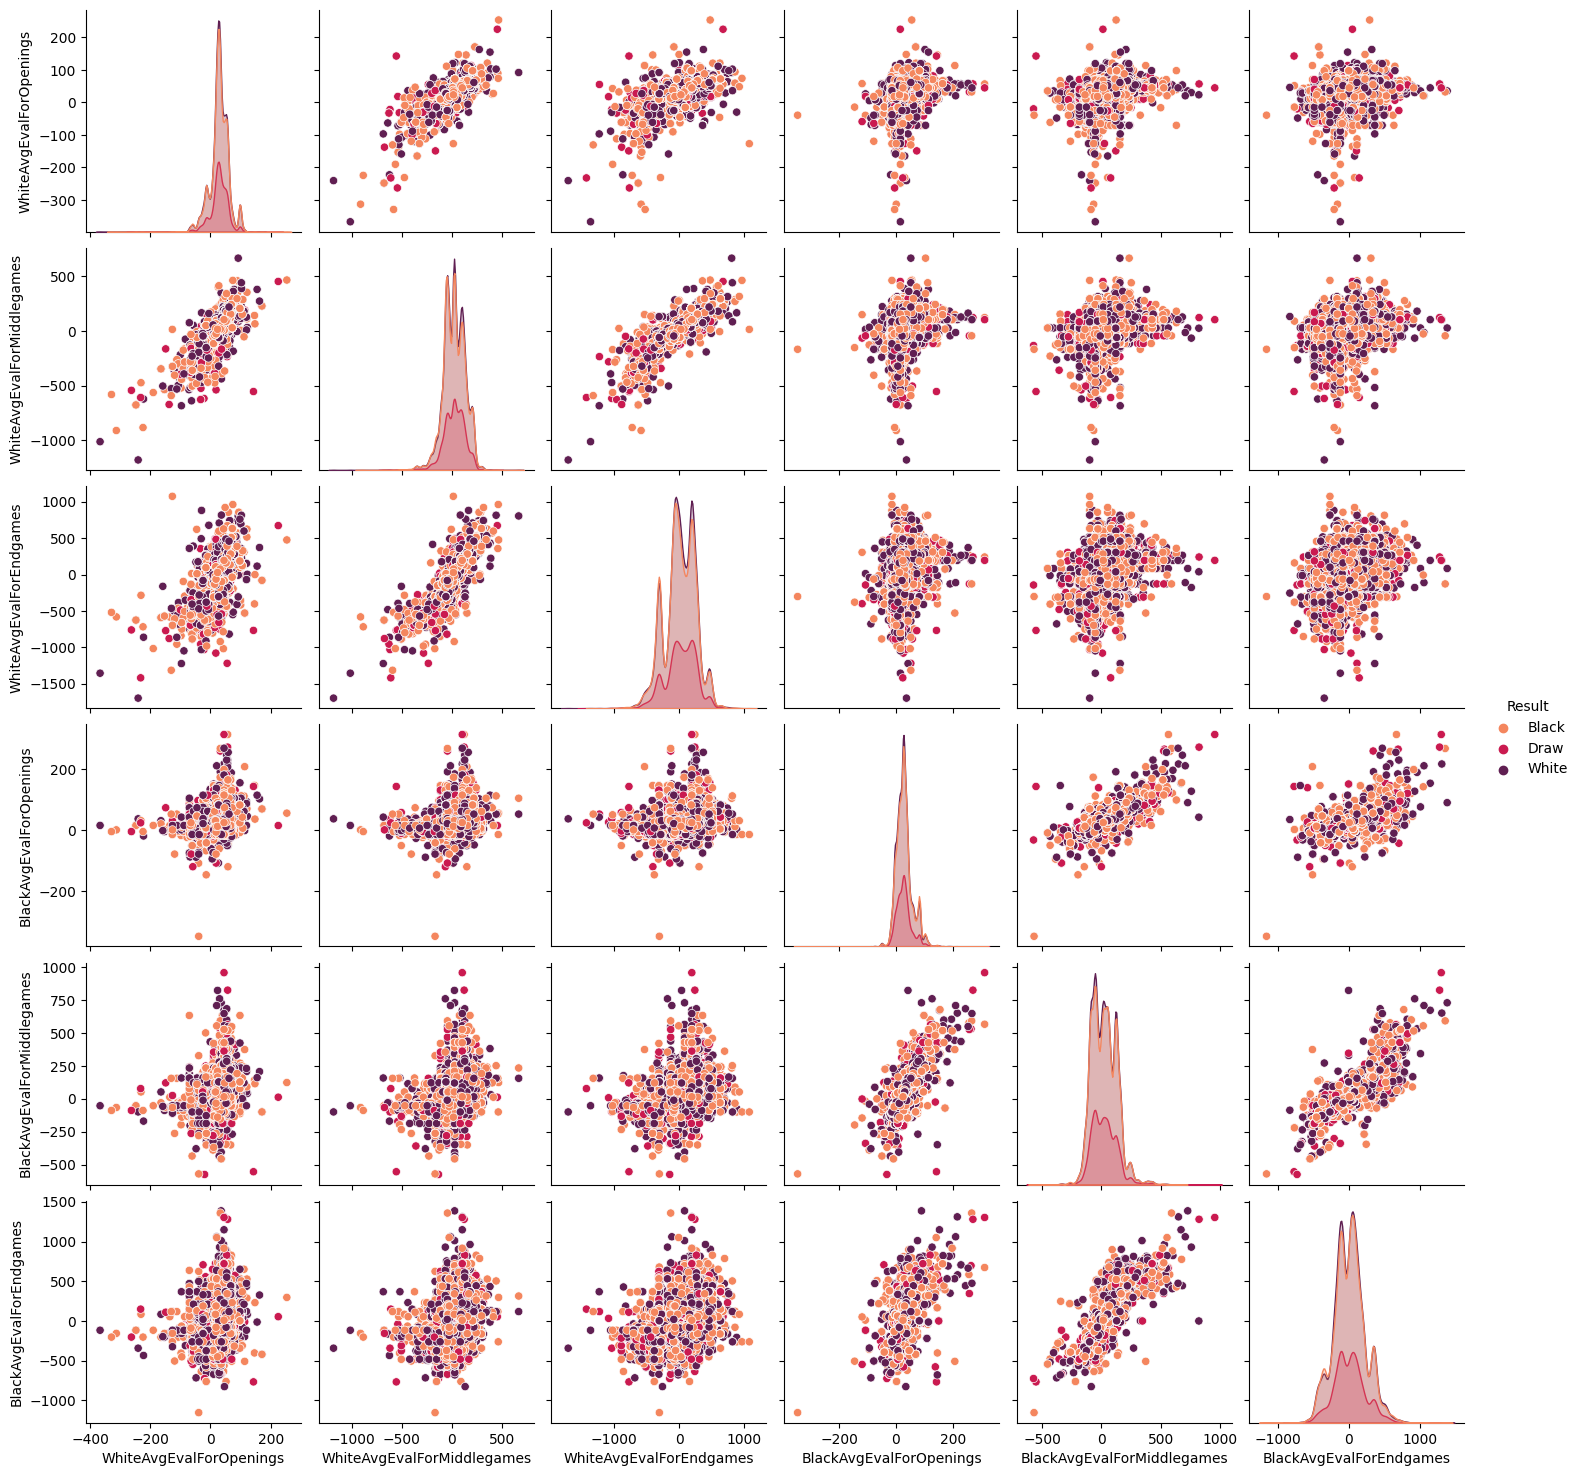

In [19]:
sns.pairplot(data=evals, hue='Result', 
             vars=evals.columns[:-2],
             palette='rocket_r')

Although we cannot see interactions between player evaluation and result, we do witness indicators of a players performance based on features of their player evaluations. A lower evaluation in a ceratin aspect of ones game is strongly correlated with lower evaluations across scores. This provides much stronger implications of a players overall ability beyond simply looking at one's Elo rating.

This plot also provides valuable insight into the matchmaking of the server from which we pulled our data, as players are matched according to their playing ability very reliably. Tn general, there are identical and relatively normal distributions centered at 0 for both players in plots measuring White and Black evaluations. This general similarity in player ability may increase the difficulty of identifing which specific features are responsible for a player winning. A win could simply be a result of a better game played on a specific day, which we might expect from more inversely correlated interactions between opponent evals(one high vs the other low), however, other more similar opponent interactions might be difficult to pull a prediction from. This is something to keep in mind as we proceed with our models and further analysis.

# Proposed Solution

In this project we aim to evaluate the effectiveness of three different machine learning implementations at classifying the outcomes of FIDE titled chess games from unlabeled match data. Each model (Logisitc Regression, Random Forests, and the Deep NN) will be trained on a curated sample database consisting of several derived features representing characteristics of the games pertinent to the games’ outcomes. We chose logistic regression as our first model because it is a solid classification method. While we fear that it may be too simple for this task, we believe it is a good, simple baseline to compare with more complex models. We also plan to try random forests because the complex decision boundaries may be sufficient for consistently accurate and generalizable predictions. Finally, we will use a deep neural network because it seems to be the baseline method used for very similar problems regarding chess game outcomes, and given our large dataset, we hope it will pick up on important nuances that are neglected by logistic regression and random forest. 

For this we will need to use a variety of tools for accessing and manipulating the data to generate these special features. Pandas and numpy will be instrumental in this preprocessing stage. Further imports will be required for sklearn and matplot lib for training/validation and analysis, as well as an additional library called pychess will be necessary for processing chess engine ratings and to help format game data for preprocessing. We will be using built in methods for training and validating data provided by sklearn. To measure the effectiveness of our model we will take Sayon Bhattacharjee’s LSTM solution published in the _Towards Data Science_ article found [here](https://towardsdatascience.com/predicting-professional-players-chess-moves-with-deep-learning-9de6e305109e). Sayon's LTSM solution uses two convolutional neural networks; one "predicts" where a particular piece moved from, and the other predicts where a piece will move. These networks are combined as a time series to model a classification problem with three possible output categories corresponding with the outcome: black wins, white wins, or there is a draw. The effectiveness of this model can simply be measured by classification accuracy using metrics discussed in the following section.

# Evaluation Metrics

In the evaluation of binary chess outcome classification, simply implementing a confusion matrix of our algorithm’s results is most appropriate for visualizing the performance. In this situation, there is equal cost associated with both false positive rates and false negative rates, and there is equal cost associated with true positives and true negative rates. Consequently, we care about both the recall and precision of our models equally. This suggests that an f1-score is one primary metric we should use, since it is equally sensitive to both recall and precision. For example, predicting that Player 1 wins when they actually win is equally as important as being ‘accurate’ when predicting that Player 1 will win; the cost of a false positive is no different than the cost of a false negative. We may also explore some other classification error metrics such as likelihood ratios.

$$precision = \frac{TP}{TP + FP}$$
$$recall = \frac{TP}{TP + FN}$$
$$F1-Score = \frac{2*precision*recall}{precision + recall}$$

# Results

The first step, as with any machine learning process, is to the split the data into useful training and test sets. We will do this using our `df_train` dataset, which is preprocessed with float64 and one-hot encoded features. This dataset still contains the ground truth labels as well, so we will drop them before splitting up our data.

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RepeatedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import numpy as np

import matplotlib.pyplot as plt

### Logistic Regression

The hyperparameter tuning for this Logistic Regression model included the `penalty`, `C`, and `solver` parameters. Included in the optimization of this model is the preprocessing which preceded the model's GridSearchCV tuning. The aim of this preprocessing was to standardize all values to reasonable ranges in which it is possible to apply Logistic Regression upon it successfully for the purposes of multi-class prediction.

The grid search process determined that the best hyperparameters were: `penalty="l1"`, `C=1e+04`, and `solver="liblinear"`. At baseline, Logistic Regression performed at around a 57% accuracy, but through Grid Search and preprocessing, we were able to improve this performance by about 13% and provide reasonable predictions given the simplicity of this model.

Overall, the model performed at a reasonable accuracy.

#### Setting Up Data and Models

In [21]:
# split data into training and test sets

# drop ground truth and one-hot encoded variables from feature set
X = (df_train.drop(columns=df_train.columns[df_train.columns.str.contains('A_') + 
                                            df_train.columns.str.contains('B_') + 
                                            df_train.columns.str.contains('C_')])
    )
y = cleaned['Result']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [22]:
# standard model
logreg = LogisticRegression(penalty='l1',
                            solver='liblinear',
                            C=1e+04)

# preprocessing, including scaling and transforming features
preproc = ColumnTransformer(
        transformers=[
            ('white-as-is', FunctionTransformer(), ['WhiteAvgEmtForOpenings',
                                                    'WhiteAvgEmtForMiddlegames',
                                                    'WhiteAvgEmtForEndgames']),
            
            ('black-as-is', FunctionTransformer(), ['BlackAvgEmtForOpenings',
                                                    'BlackAvgEmtForMiddlegames',
                                                    'BlackAvgEmtForEndgames']),
            
            ('white-scale', StandardScaler(), ['WhiteAvgEvalForOpenings', 
                                              'WhiteAvgEvalForMiddlegames', 
                                              'WhiteAvgEvalForEndgames']),
            
            ('black-scale', StandardScaler(), ['BlackAvgEvalForOpenings', 
                                              'BlackAvgEvalForMiddlegames', 
                                              'BlackAvgEvalForEndgames']),
            
            ('std scale', StandardScaler(), ['WhiteAvgPlyCount', 'BlackAvgPlyCount',
                                             'WhiteAvgRD', 'BlackAvgRD'])
        ]
    )

# rudimentary model
pl_plain = Pipeline([
    ('logreg', logreg)
])

# model with preprocessing
pl = Pipeline([
    ('preprocessing', preproc),
    ('logreg', logreg)
])

# train both models: one without processing, and one with
pl_plain.fit(X_train, y_train)
pl.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('white-as-is',
                                                  FunctionTransformer(),
                                                  ['WhiteAvgEmtForOpenings',
                                                   'WhiteAvgEmtForMiddlegames',
                                                   'WhiteAvgEmtForEndgames']),
                                                 ('black-as-is',
                                                  FunctionTransformer(),
                                                  ['BlackAvgEmtForOpenings',
                                                   'BlackAvgEmtForMiddlegames',
                                                   'BlackAvgEmtForEndgames']),
                                                 ('white-scale',
                                                  StandardScaler(),
                                                  ['WhiteAvgEvalFor...gs',
                                                   'WhiteAvgEvalForMiddlegames',
                                                   'WhiteAvgEvalForEndgames']),
                                                 ('black-scale',
                                                  StandardScaler(),
                                                  ['BlackAvgEvalForOpenings',
                                                   'BlackAvgEvalForMiddlegames',
                                                   'BlackAvgEvalForEndgames']),
                                                 ('std scale', StandardScaler(),
                                                  ['WhiteAvgPlyCount',
                                                   'BlackAvgPlyCount',
                                                   'WhiteAvgRD',
                                                   'BlackAvgRD'])])),
                ('logreg',
                 LogisticRegression(C=10000.0, penalty='l1',
                                    solver='liblinear'))])

#### Comparison With and Without Preprocessing

In [23]:
# train each model 100 times and produce plot to observe differences in accuracy

plain = []
preproc = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    plain.append(pl_plain.score(X_test, y_test))
    preproc.append(pl.score(X_test, y_test))

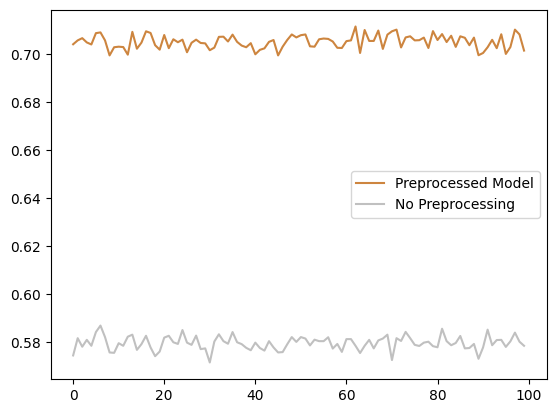

In [24]:
plt.plot(preproc, label = "Preprocessed Model", color='peru')
plt.plot(plain, label = "No Preprocessing", color='silver')
plt.legend()
plt.show()

As we can see in the plot above, preprocessing made a world of a difference in terms of improving the base model's accuracy.

#### Performance

              precision    recall  f1-score   support

       Black       0.71      0.74      0.73      5363
        Draw       0.70      0.43      0.53      1973
       White       0.69      0.76      0.73      5606

    accuracy                           0.70     12942
   macro avg       0.70      0.64      0.66     12942
weighted avg       0.70      0.70      0.70     12942



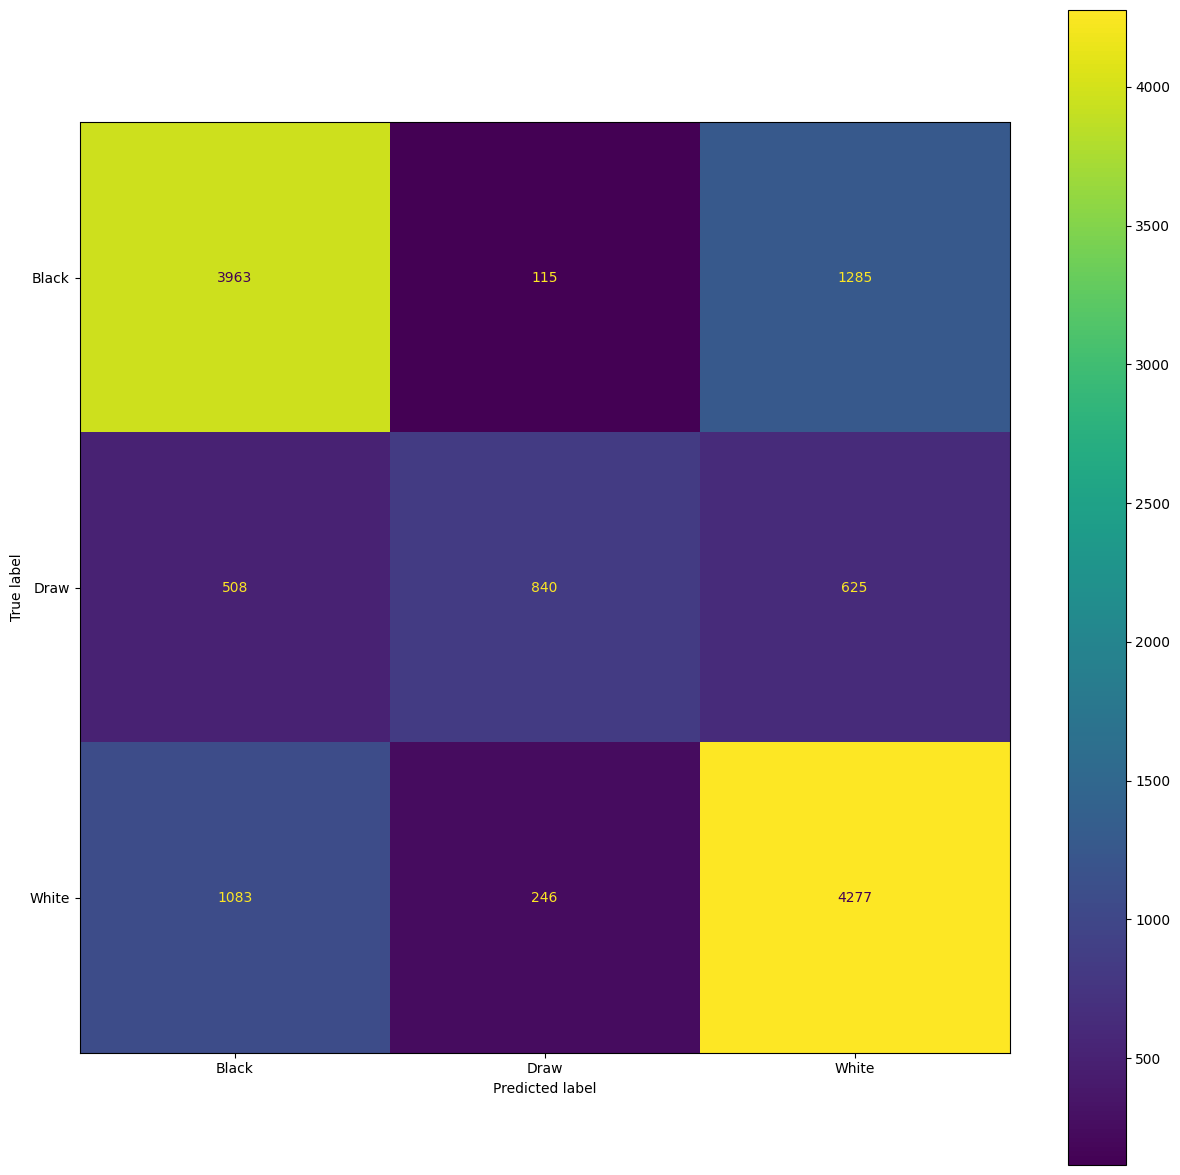

In [25]:
# get predictions from logistic regression
y_pred = pl.predict(X_test)

# display results
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pl.classes_)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)
plt.show()

Overall, the results of our logistic regression model are very promising. It appears to predict outcomes of black and white winning quite will, with f-scores of 0.73 and 0.74 respectively and similar precision and recall scores for each category. Unfortunately, it appears that the model isn't as effective at predicting "draws"; the precision score is good at 0.70, but the recall score is low at 0.44.

### Random Forest

In training our random forest, we didn't elect to use a pipeline because the data was already properly formatted. The only step that would generally be left is to scale the numerical features via z-transformation, but random forests are robust to non-standardized features. 

We originially trained a rudimentary model and observed that the test performance was about 14% lower than the training performance. This could indicate overfitting, so we tried some pruning methods. The hyperparameters `ccp_alpha`, `max_depth`, `max_leaf_nodes`, and `min_sample_split` help with pruning. The hyperparameter optimization for our random forest took about an hour to train. We performed grid search over a number of hyperparameters, including `n_estimators` and `max_features`, and the ones mentioned previously. Contrary to our prediction, the grid search with all these variables determined that no pruning produced the best results. The model was likely not overfitting as much as we initially thought. 

We also tried reducing some of the default variability among learners by eliminating the random feature selection during training of each decision tree, and this eliminated a small amount of overfitting. 

The training and test accuracies as a result of the hyperparameter selection process are as follows:

#### Data Setup

In [26]:
# split data into training and test sets

# drop all ground truth labels from the processed training data
X = df_train.drop(columns=df_train.columns[df_train.columns.str.contains('A_') + df_train.columns.str.contains('B_')])
# get the desired ground truth labels
y = cleaned['Result']
# split data for training and accuracy testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#### Training

In [27]:
rf = RandomForestClassifier(n_estimators=1000, max_features=None, n_jobs=-1)

# train the random forest without one-hot encoded variables to decrease dimensions
rf.fit(X_train.drop(columns=X_train.columns[X_train.columns.str.contains('C_')]), y_train)

RandomForestClassifier(max_features=None, n_estimators=1000, n_jobs=-1)

#### Performance

              precision    recall  f1-score   support

       Black       0.73      0.75      0.74      2747
        Draw       0.64      0.47      0.54      1000
       White       0.69      0.75      0.72      2724

    accuracy                           0.70      6471
   macro avg       0.69      0.66      0.67      6471
weighted avg       0.70      0.70      0.70      6471



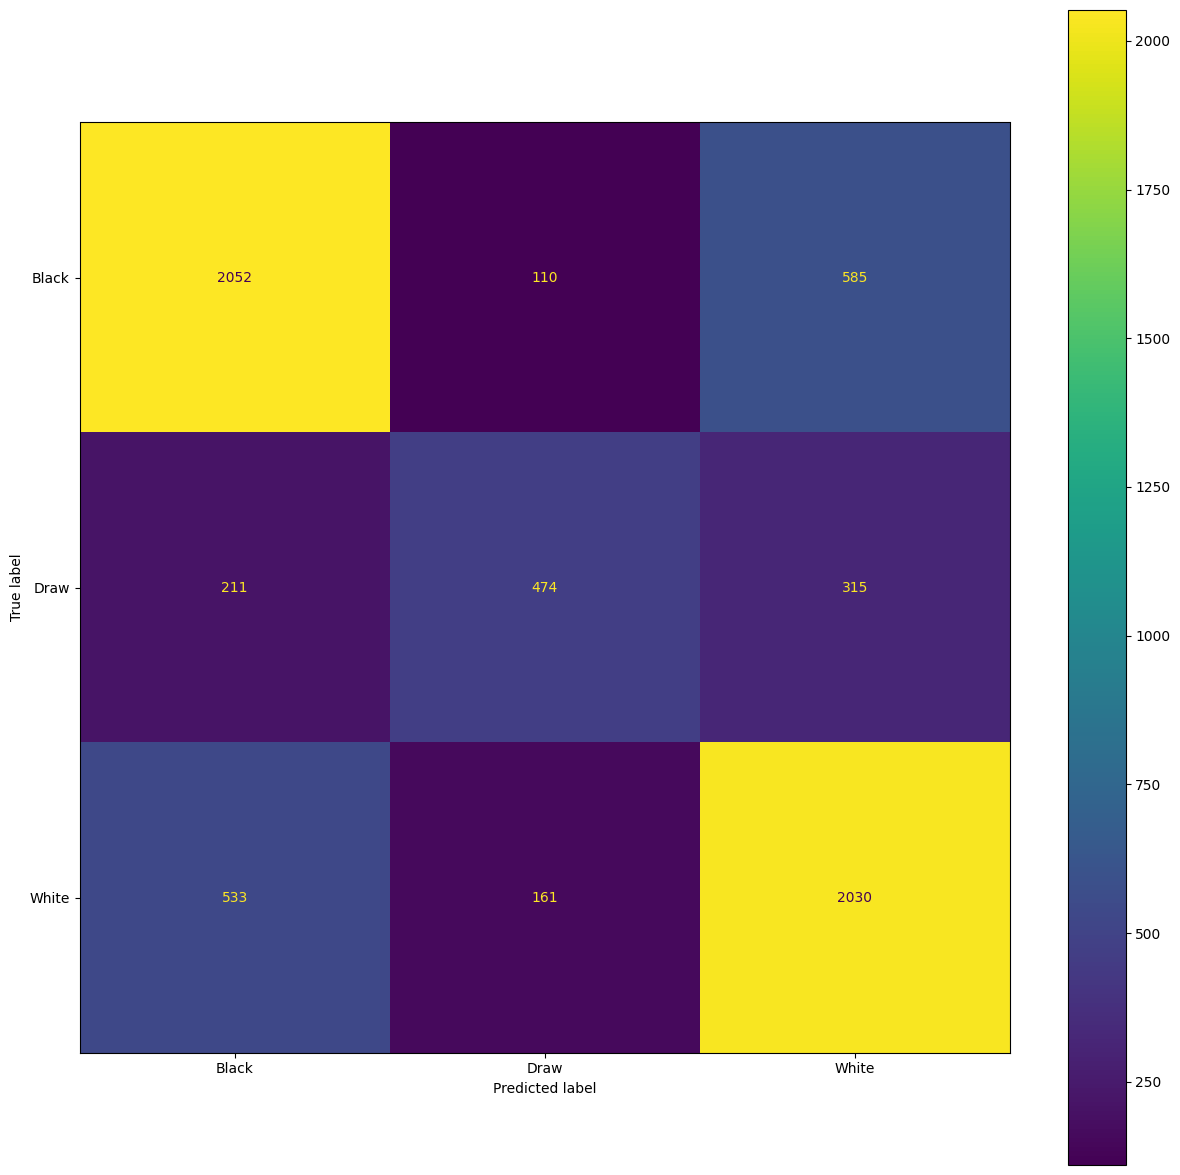

In [28]:
# predict categories from the test set
y_pred = rf.predict(X_test.drop(columns=X_train.columns[X_train.columns.str.contains('C_')]))

# display results
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)
plt.show()

Our random forest results are very similar to those of the logistic regression. The random forest was quite effective at predicting outcomes with either black or white winning, but it was less effective at predicting games that end in a draw. This is interesting given that the "draw" category had the most datapoints. Overall, the f-scores for each category here are very similar to those of from the logistic regression, but the random forest performs better.

#### Deep Neural Network

For our last model, the deep neural network, we will need to write estimator and classifier classes to enable the interaction between the `pytorch` and `sklearn` libraries.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.preprocessing import StandardScaler

# Define the PyTorch classifier
class PyTorchClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(PyTorchClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

# Define the PyTorch estimator for scikit-learn compatibility
class PyTorchEstimator:
    def __init__(self, input_size, hidden_size, num_classes, lr=0.001, batch_size=32, epochs=100):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.model = PyTorchClassifier(input_size, hidden_size, num_classes)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def fit(self, X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.long).to(self.device)
        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        for epoch in range(self.epochs):
            epoch_loss = 0.0
            for batch in dataloader:
                X_batch, y_batch = batch
                X_batch = X_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                optimizer.zero_grad()
                y_pred = self.model(X_batch)
                loss = criterion(y_pred, y_batch)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            # print(f"Epoch {epoch+1}: Loss = {epoch_loss/len(dataloader):.4f}")

    def predict(self, X):
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
            y_pred = self.model(X_tensor)
            _, predicted = torch.max(y_pred.data, 1)
        return predicted.cpu().numpy()
    
    def get_params(self, deep=True):
        return {'input_size': self.input_size,
                'hidden_size': self.hidden_size,
                'num_classes': self.num_classes,
                'lr': self.lr,
                'batch_size': self.batch_size,
                'epochs': self.epochs}

    def set_params(self, **params):
        self.input_size = params.get('input_size', self.input_size)
        self.hidden_size = params.get('hidden_size', self.hidden_size)
        self.num_classes = params.get('num_classes', self.num_classes)
        self.lr = params.get('lr', self.lr)
        self.batch_size = params.get('batch_size', self.batch_size)
        self.epochs = params.get('epochs', self.epochs)
        self.model = PyTorchClassifier(self.input_size, self.hidden_size, self.num_classes)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        return self

Now that we have the proper estimators and classifiers to train our deep neural network, we can prepare our data and perform grid search to determine the best possible model. Our grid search will hold some variables fixed, including `input_size`, `num_classes`, `batch_size`, and `epochs`, since they are determined by the nature of our problem. However, we will vary `hidden_size` and `lr` as these heavily influence performance and there is no obvious rule of thumb for choosing their values.

In [ ]:
# Normalize input features
scaler = StandardScaler()
X_norm = scaler.fit_transform(df_train.drop(columns=df_train.columns[df_train.columns.str.contains('B_') + df_train.columns.str.contains('A_')]))

# remove nan and null values
mask = pd.isnull(X_norm).any(axis=1)
X = X_norm[~mask]
y = cleaned['Result'].astype('category').cat.codes.values
y = y[~mask]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Define the parameter grid to search over
param_grid = {'input_size': [X.shape[1]],
              'hidden_size': [10, 50, 100],
              'num_classes': [3],
              'lr': [0.0001, 0.001, 0.01],
              'batch_size': [64],
              'epochs': [100]
             }

scoring = {'Accuracy': make_scorer(accuracy_score)}

# Wrap the PyTorch classifier in a scikit-learn estimator
estimator = PyTorchEstimator(input_size=X.shape[1], hidden_size=50, num_classes=3)

print("X min:", np.min(X))
print("X max:", np.max(X))
print("X nan count:", np.isnan(X).sum())
print("y min:", np.min(y))
print("y max:", np.max(y))
print("y nan count:", np.isnan(y).sum())
grid = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring=scoring, refit='Accuracy', return_train_score=True, cv=5, verbose=1)
grid.fit(X_train, y_train)

In [ ]:
print(grid.best_params_)

{'batch_size': 64, 'epochs': 100, 'hidden_size': 10, 'input_size': 496, 'lr': 0.0001, 'num_classes': 3}


After training, it appears that the optimal hyperparameters are `hidden_size = 10` and `lr = 0.0001`. Now we can form predictions from our test set and observe model performance.

              precision    recall  f1-score   support

           0       0.71      0.72      0.72      2725
           1       0.61      0.42      0.50       979
           2       0.68      0.75      0.71      2796

    accuracy                           0.69      6500
   macro avg       0.67      0.63      0.64      6500
weighted avg       0.68      0.69      0.68      6500



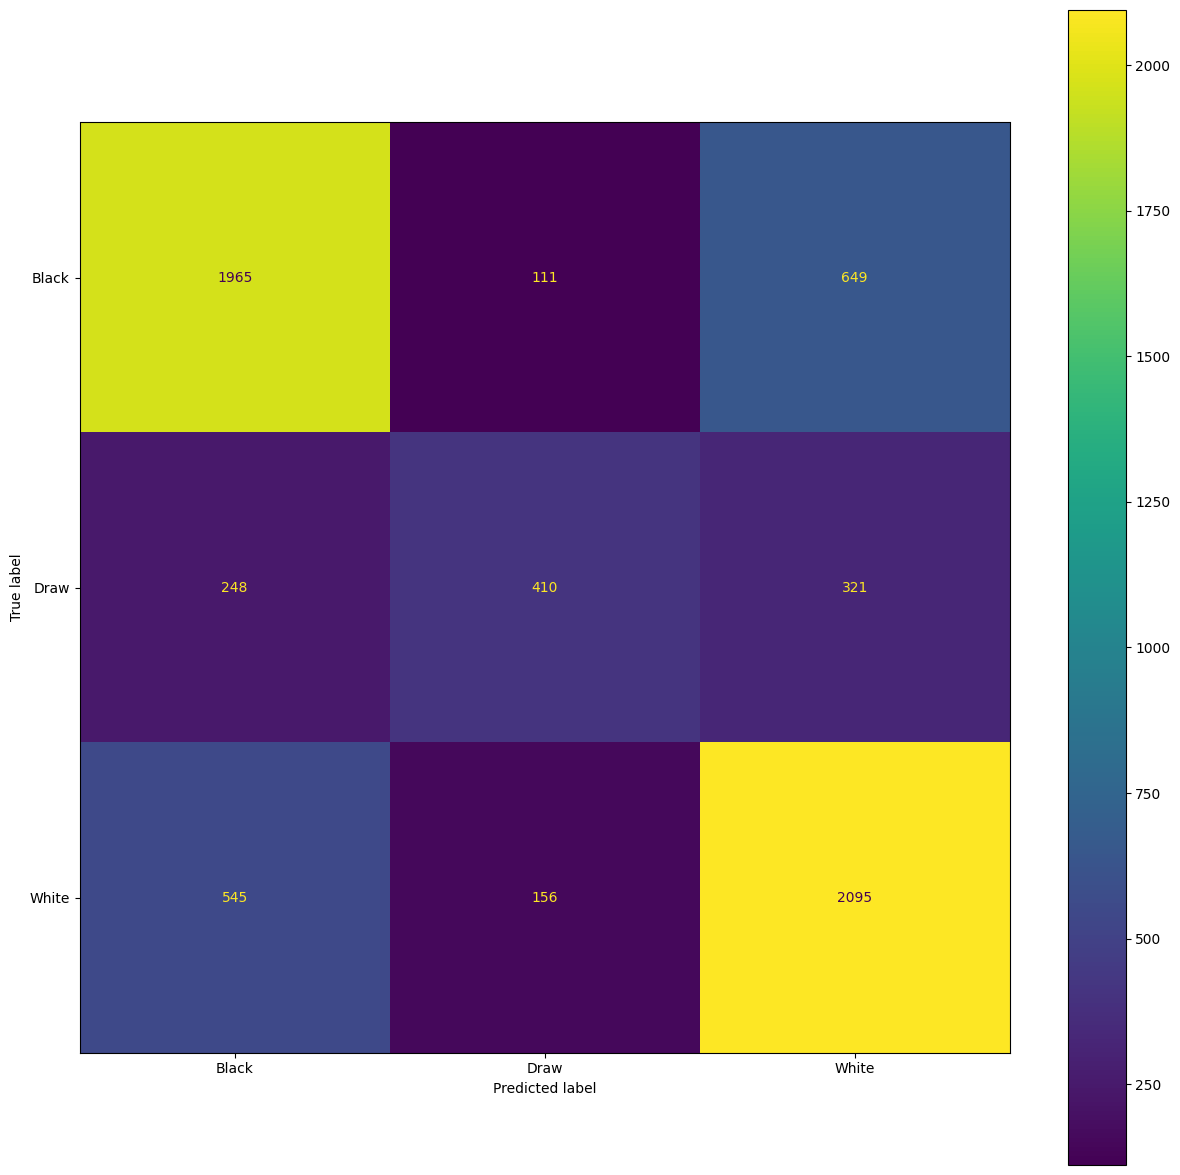

In [ ]:
y_pred = grid.best_estimator_.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(cleaned[['Result']]))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)
plt.show()

Our DNN results are very similar to those of both the logistic regression and the random forest. All three models were quite effective at predicting outcomes with either black or white winning, but they were less effective at predicting games that end in a draw. Overall, the f-scores for each category are similar for each model we tested.

# __NEEDS WORK__
You may have done tons of work on this. Not all of it belongs here. 

Reports should have a __narrative__. Once you've looked through all your results over the quarter, decide on one main point and 2-4 secondary points you want us to understand. Include the detailed code and analysis results of those points only; you should spend more time/code/plots on your main point than the others.

If you went down any blind alleys that you later decided to not pursue, please don't abuse the TAs time by throwing in 81 lines of code and 4 plots related to something you actually abandoned.  Consider deleting things that are not important to your narrative.  If its slightly relevant to the narrative or you just want us to know you tried something, you could keep it in by summarizing the result in this report in a sentence or two, moving the actual analysis to another file in your repo, and providing us a link to that file.

### Subsection 1

You will likely have different subsections as you go through your report. For instance you might start with an analysis of the dataset/problem and from there you might be able to draw out the kinds of algorithms that are / aren't appropriate to tackle the solution.  Or something else completely if this isn't the way your project works.

### Subsection 2

Another likely section is if you are doing any feature selection through cross-validation or hand-design/validation of features/transformations of the data

### Subsection 3

Probably you need to describe the base model and demonstrate its performance.  Maybe you include a learning curve to show whether you have enough data to do train/validate/test split or have to go to k-folds or LOOCV or ???

### Subsection 4

Perhaps some exploration of the model selection (hyper-parameters) or algorithm selection task. Validation curves, plots showing the variability of perfromance across folds of the cross-validation, etc. If you're doing one, the outcome of the null hypothesis test or parsimony principle check to show how you are selecting the best model.

### Subsection 5 

Maybe you do model selection again, but using a different kind of metric than before?



# Discussion

### Interpreting the result
# __NEEDS WORK__
OK, you've given us quite a bit of tech informaiton above, now its time to tell us what to pay attention to in all that.  Think clearly about your results, decide on one main point and 2-4 secondary points you want us to understand. Highlight HOW your results support those points.  You probably want 2-5 sentences per point.

#### Main point: Logistic regression and random forests equally picked out some of the differentiating characteristics for black and white, but couldn't do the same for draw outcomes. Can the neural net do this? We shall see

### Limitations
While we did have a fairly large dataset consisting of over 20,000 games, there are limitations to the data that we had access to. One limitation is that our data is only representative of standard games with average ratings greater than 2000, which may not be reflective of games played by less experienced players or non-professional players. Additionally, our dataset only includes games played from March of 2022 to February of 2023, which may not be an accurate representation of every play style that could have been analyzed. The features we used in our analysis were limited to only those available in the database, and did not include potentially important factors such as the players' physical/mental state or other external factors that may have effected game oucomes in some way. Incorporating additional data could potentially change the nature of the problem and improve the effectiveness of our models. In addition, we were limited by the number of hyperparameters we were able to explore due to computational constraints. With more time and resources, it would have been beneficial to explore additional hyperparameters and perform a more thorough cross-validation to ensure that our models are better able to predict on unseen data. While our models were able to achieve a reasonable accuracy in predicting game outcomes, it is important to keep in mind that chess is a complex game with many different factors contributing to its outcomes. Our models are limited in their ability to capture all of these factors, and their predictions should be interpreted with caution.
### Ethics & Privacy

In the case of data privacy, we see no major concerns with our data as it is publicly available FIDE match information that is made public anytime a chess player agrees to a FIDE match. The biggest ethical concern that we could potentially see with the production of any well-functioning model for predicting FIDE titled chess matches would be the use of the model for gambling purposes. Although we don't foresee the prediction accuracy of our models being able to give a definitive answer to who will win a match, a good model could lead to an increase in chess match gambling which comes with its own host of harmful consequences. Additionally, we can highlight the concern that a prediction model could affect the way that players go about their matches if they know the predicted outcome of a game given specific features. This could be seen as an unfair advantage. The model, if then re-trained with new data, could also perform much more poorly as outcomes would now be affected by prior knowledge of the potential outcome of a game which would complicate further predictions.

### Conclusion
# __NEEDS WORK__
Reiterate your main point and in just a few sentences tell us how your results support it. Mention how this work would fit in the background/context of other work in this field if you can. Suggest directions for future work if you want to.